<a href="https://colab.research.google.com/github/Rohit-Roby/Project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install objaverse
!pip install trimesh
!pip install open3d
!pip install torchsummary

In [2]:
# Import libraries
import objaverse
import nltk
from nltk.corpus import stopwords  # for stop word removal
from nltk.stem import PorterStemmer  # for stemming (or use WordNetLemmatizer for lemmatization)
import string
import trimesh
import os
import shutil
import multiprocessing
nltk.download('stopwords')
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
import torch
import torchsummary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Loading the dataset files and dowloading 3d model**

In [3]:
#loading Uids
uids = objaverse.load_uids()
len(uids), type(uids)


(798759, list)

In [4]:

# lvis_annotations
lvis_annotations = objaverse.load_lvis_annotations()

# Sort the dictionary by value in descending order and select the top 20 items
items = dict(sorted(lvis_annotations.items(), key=lambda item: len(item[1]), reverse=True))
items.keys()

dict_keys(['chair', 'seashell', 'antenna', 'shield', 'snowman', 'chandelier', 'gravestone', 'cone', 'control', 'sword', 'armor', 'doughnut', 'banana', 'ring', 'fireplug', 'mushroom', 'fighter_jet', 'figurine', 'monitor_(computer_equipment) computer_monitor', 'mug', 'owl', 'shoe', 'helicopter', 'skateboard', 'soccer_ball', 'rifle', 'teddy_bear', 'bicycle', 'die', 'guitar', 'heart', 'race_car', 'lion', 'mask', 'gun', 'pumpkin', 'rabbit', 'sculpture', 'spectacles', 'apple', 'wedding_ring', 'telephone', 'elephant', 'police_cruiser', 'airplane', 'crab_(animal)', 'globe', 'lamppost', 'lampshade', 'windmill', 'toilet', 'trunk', 'pickup_truck', 'fan', 'mascot', 'shark', 'machine_gun', 'piano', 'pony', 'motor_vehicle', 'vase', 'sunglasses', 'wolf', 'frog', 'pottery', 'bookcase', 'penguin', 'spider', 'car_(automobile)', 'keg', 'table', 'television_set', 'wineglass', 'butterfly', 'crate', 'necklace', 'computer_keyboard', 'fire_extinguisher', 'manhole', 'armchair', 'coin', 'pizza', 'sportswear', '

In [5]:
len(items)

1156

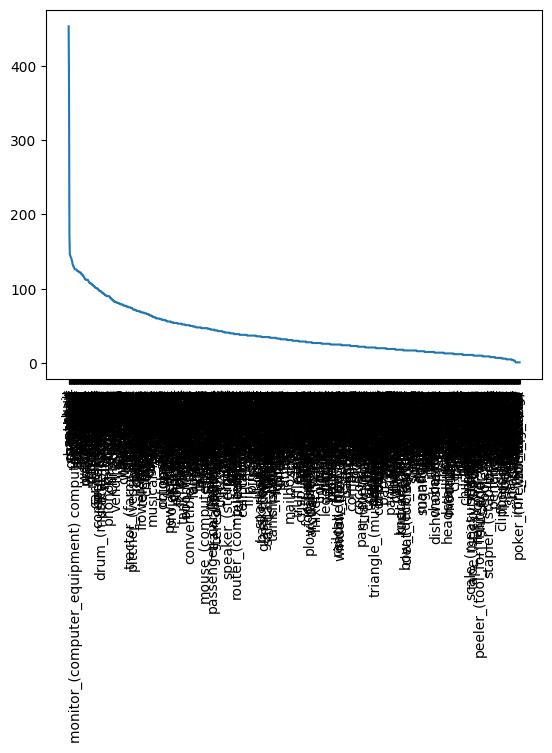

In [6]:

# Plot the keys against the lengths of the values
plt.xticks(rotation='vertical')
plt.plot(list(items.keys()), [len(value) for value in items.values()])
plt.show()


In [7]:
# # Load Objaverse annotations
# uids = []  # Initialize an empty list
# for uid_list in items.values():
#     uids.extend(uid_list)  # Add UIDs individually


In [8]:
len(uids)

798759

In [9]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [10]:
annotations = objaverse.load_annotations(uids)

 99%|█████████▉| 159/160 [01:06<00:00,  2.39it/s]


In [11]:
# objaverse_description = []
for annotation in annotations.values():
    if isinstance(annotation, dict):
        tags = annotation.get("tags")  # No default value, get returns 'None' if key is missing
        if tags:  # Check if tags exists
            tag_descriptions = [tag['name'] for tag in tags]
            # ... (Rest of your code)
            description = " ".join(tag_descriptions)
             # Store tags and description with annotation
            annotation["description"] = description  # adding a description field
            # objaverse_description.append(description)

In [12]:
import pandas as pd
df = pd.DataFrame()
df['uids'] = uids



**Preprocessing of Text Description**

In [13]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
def clean_description(description):
    # Define stop words
    stop_words = set(stopwords.words("english"))


    # Remove punctuation
    text = description.translate(str.maketrans('', '', string.punctuation))

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lowercase conversion
    text = text.lower()

    # Stemming (or lemmatization)
    stemmer = PorterStemmer()  # You can replace this with WordNetLemmatizer for lemmatization
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


df['description'] = df['uids'].map(lambda uid: clean_description( annotations[uid]['description']))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import numpy as np
df['description'].replace('', np.nan, inplace=True)
df = df.dropna()

In [15]:
processes = multiprocessing.cpu_count()
processes
objects = objaverse.load_objects(
    uids = df['uids'].iloc[:2500],
    download_processes = processes
)

starting download of 2500 objects with 16 processes
Downloaded 1 / 2500 Downloadedobjects
 2 / 2500 objects
Downloaded 3 / 2500DownloadedDownloaded  objects 5
 5/ /  2500Downloaded2500  objectsobjects
6
  / 2500 objects
Downloaded 7 Downloaded/  25009Downloaded   objects/9
  2500/  objects2500
 objects
Downloaded 10 / 2500 objects
Downloaded 11 / 2500 objects
Downloaded 12 Downloaded/  250013  objects/
 2500 objects
Downloaded 14 / 2500 objects
Downloaded 15 / 2500 objects
Downloaded 16 / 2500 objects
Downloaded 17 / 2500 objects
Downloaded 18 / 2500 objects
Downloaded 19 / 2500 objects
Downloaded 20 / 2500 objects
Downloaded 21 / 2500 objectsDownloaded
 22 / 2500 objects
Downloaded 23 / 2500 objects
DownloadedDownloaded  2525  //  25002500  objectsobjects

Downloaded 26 / 2500 objects
Downloaded 27 / 2500 objects
DownloadedDownloaded  2929  //  25002500  objectsobjects

Downloaded Downloaded31  31/  /2500  objects2500
 objects
Downloaded 32 / 2500 objects
Downloaded 33 / 2500 objects


In [16]:
# Define the subfolder and parent folder paths
parent_dir = '/root/.objaverse/hf-objaverse-v1/glbs'

# Walk through the parent directory
for subdir, dirs, files in os.walk(parent_dir):
    for file in files:
        # Construct the file path
        file_path = os.path.join(subdir, file)
        # Construct the destination path
        dest_path = os.path.join(parent_dir, file)
        # Move the file to the parent directory
        shutil.move(file_path, dest_path)
    # If the current directory is not the parent directory, delete the subdirectory
    if subdir != parent_dir:
        os.rmdir(subdir)

df['glb_path'] = df['uids'].iloc[:2500].map(lambda x: objects[x])

In [17]:
df.head()

,uids,description,glb_path
0,8476c4170df24cf5bbe6967222d1a42d,stair staircas staircon,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
1,8ff7f1f2465347cd8b80c9b206c2781e,xyzschooldraftpunk3,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
2,c786b97d08b94d02a1fa3b87d2e86cf1,posi joist layout,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
3,139331da744542009f146018fd0e05f4,fridaynightfunkin whitti,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
5,efd35e7d21ac482688c294e3b6c9f74e,train crisi photogrammetrydron photogrammetri,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...


In [18]:
# import re
# # Function to remove "/glbs"
# def remove_glbs(path):
#     return re.sub(r'\d{3}-\d{3}/', '', path)    # Replace '/glbs' with an empty string

# # Apply the function using map
# df['glb_path'] = df['glb_path'].map(remove_glbs)

In [19]:
import time

def verbose_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.2f} seconds to execute.")
        return result
    return wrapper

In [20]:
@verbose_time
def custom_function():
    # Your custom function code
    pass

# To use the verbose time decorator, just call your function:
custom_function()

custom_function took 0.00 seconds to execute.


In [21]:
@verbose_time
def custom_function():
    # Your custom function code
    pass

# To use the verbose time decorator, just call your function:
custom_function()

custom_function took 0.00 seconds to execute.


**Preprocessing of 3d model into point cloud**

In [22]:
import os
def get_model_paths(base_dir):
    model_paths = []
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".glb"):
                file_path = os.path.join(subdir, file)
                model_paths.append(file_path)
    return model_paths
base_dir ='/root/.objaverse/hf-objaverse-v1/glbs'
model_paths = get_model_paths(base_dir)

In [23]:
df.head()

,uids,description,glb_path
0,8476c4170df24cf5bbe6967222d1a42d,stair staircas staircon,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
1,8ff7f1f2465347cd8b80c9b206c2781e,xyzschooldraftpunk3,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
2,c786b97d08b94d02a1fa3b87d2e86cf1,posi joist layout,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
3,139331da744542009f146018fd0e05f4,fridaynightfunkin whitti,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
5,efd35e7d21ac482688c294e3b6c9f74e,train crisi photogrammetrydron photogrammetri,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...


In [24]:
df.to_csv('/root/.objaverse/Dataset')
import pandas as pd
df = pd.read_csv('/root/.objaverse/Dataset')

<ipython-input-24-ea1f21cd394f>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/root/.objaverse/Dataset')


In [25]:
# from mpl_toolkits.mplot3d import Axes3D

# glbs = model_paths[0:5]
# # Create a figure and axes for the subplots
# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# # Loop through each subplot and display the mesh
# for i, ax in enumerate(axs.flat):
#     # Plot mesh in each subplot
#     for glb in glbs:
#       if glb:
#           mesh = o3d.io.read_triangle_mesh(glb)
#           ax = o3d.visualization.draw_plotly([mesh])
#       else:
#           # Hide empty subplots
#           ax.axis('off')
# plt.show()


**Voxelization using numpy**

In [26]:
import numpy as np
import os
from scipy.ndimage import zoom
from multiprocessing import Pool, cpu_count
# import pygltflib

**voxelization using open3d**

In [27]:
dir = '/root/.objaverse/hf-objaverse-v1/glbs'
num_processes = multiprocessing.cpu_count()  # Use the number of CPU cores


In [28]:
df.head()

,Unnamed: 0,uids,description,glb_path
0,0,8476c4170df24cf5bbe6967222d1a42d,stair staircas staircon,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
1,1,8ff7f1f2465347cd8b80c9b206c2781e,xyzschooldraftpunk3,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
2,2,c786b97d08b94d02a1fa3b87d2e86cf1,posi joist layout,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
3,3,139331da744542009f146018fd0e05f4,fridaynightfunkin whitti,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
4,5,efd35e7d21ac482688c294e3b6c9f74e,train crisi photogrammetrydron photogrammetri,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...


In [29]:
@verbose_time
def o3d_voxelize(filepath):
    mesh = o3d.io.read_triangle_mesh(filepath)
    # os.path.split(filepath)[]
    print(mesh)
    # mesh.compute_vertex_normals()
    # fit to unit cube
    mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),center=mesh.get_center())
    # o3d.visualization.draw([mesh])
    # print('voxelization')
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
    # o3d.visualization.draw([voxel_grid])
    return voxel_grid

In [68]:
@verbose_time
#we convert to pytorch tensors to use later for training the GAN
def voxel_grid_to_tensor(voxel_grid, target_shape):

    voxels = np.asarray(voxel_grid.get_voxels())
    if len(voxels) == 0:
        pass
    voxel_positions = np.array([voxel.grid_index for voxel in voxels])
    if voxel_positions.size == 0:
        pass
    max_coords = voxel_positions.max(axis=0)
    tensor_shape = tuple(max_coords + 1)
    voxel_tensor = torch.zeros(tensor_shape, dtype=torch.float32)
    voxel_tensor[tuple(voxel_positions.T)] = 1

    # Rescale tensor to target shape
    scaling_factors = [target_shape[i] / voxel_tensor.shape[i] for i in range(3)]
    voxel_tensor_rescaled = torch.tensor(zoom(voxel_tensor, scaling_factors, order=0))  # Use nearest neighbor scaling

    # Print the final shape of the tensor
    # print("Final tensor shape:", voxel_tensor_rescaled.shape)

    return voxel_tensor_rescaled



In [31]:
df.head()

,Unnamed: 0,uids,description,glb_path
0,0,8476c4170df24cf5bbe6967222d1a42d,stair staircas staircon,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
1,1,8ff7f1f2465347cd8b80c9b206c2781e,xyzschooldraftpunk3,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
2,2,c786b97d08b94d02a1fa3b87d2e86cf1,posi joist layout,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
3,3,139331da744542009f146018fd0e05f4,fridaynightfunkin whitti,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...
4,5,efd35e7d21ac482688c294e3b6c9f74e,train crisi photogrammetrydron photogrammetri,/root/.objaverse/hf-objaverse-v1/glbs/000-023/...


**Visualizing voxel grid**

In [32]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def visualize_voxel_grid(voxel_grid):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # Extract voxel grid dimensions
#     x_size, y_size, z_size = voxel_grid.shape

#     # Iterate over each voxel
#     for x in range(1):
#         for y in range(1):
#             for z in range(1):
#                 if voxel_grid[x, y, z] == 1:  # Filled voxel
#                     ax.scatter(x, y, z, color='b')

#     # Set labels and title
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('Voxel Grid Visualization')

#     plt.show()

# # Example usage
# # voxel_grid = np.random.randint(0, 2, size=(16, 16, 16))  # Random voxel grid for demonstration
# visualize_voxel_grid(voxel_grid)

**PRETRAINED TEXT ENCODER USING T5**

In [33]:
import torch
import torch.nn as nn
import transformers
from transformers import T5ForConditionalGeneration, AutoTokenizer

In [34]:

class TextEncoder(nn.Module):
    def __init__(self, model_name="t5-large"):  # Choose a suitable T5 model size
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.transformer = T5ForConditionalGeneration.from_pretrained(model_name)

    def forward(self, text_input):
        input = self.tokenizer(text_input, return_tensors="pt")  # Tokenize input
        start_token_id = self.tokenizer.unk_token_id   # Or the correct start token for your model.
        decoder_input_ids = torch.tensor([[start_token_id]])
        input['decoder_input_ids'] = decoder_input_ids
        # print(input)
        outputs = self.transformer(**input)  # T5 model expects specific keyword arguments

        # Select appropriate representation
        # hidden_states = outputs.last_hidden_state  # Option 1: Last hidden state
        # Or potentially the encoder outputs if you need it for rephrasing later
        hidden_states = outputs.encoder_last_hidden_state

        # Simple mean pooling
        latent_representation = hidden_states.mean(dim=1)

        return latent_representation

In [35]:
sample_descriptions = ["A modern living room A minimalist bedroom A chair "]
text_encoder = TextEncoder()
for description in sample_descriptions:
    latent_representation = text_encoder(description)
    print(f"Description: {description}")
    print(f"Latent Representation: {latent_representation.shape}") # Check the shape
    print("--------------")

Description: A modern living room A minimalist bedroom A chair 
Latent Representation: torch.Size([1, 1024])
--------------


**GENERATOR AND DISCRIMINATOR MODELS**

In [259]:
import torch.nn as nn

# Generator architecture
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4 * 4),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4, 4)  # Reshape to 3D volume
        x = self.deconv(x)
        return x


In [81]:
# from torchsummary import summary

# generator = Generator(1024)
# summary(generator, (1,1024))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [258]:

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(0.1)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4 *4 , 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 256 * 4 * 4 *4 )  # Flatten
        x = self.fc(x)
        return x


**Model Training**

In [39]:
# voxel_tensors  # List of voxel tensors
text_descriptions = df['description'].tolist()   #
# List of annotations corresponding to voxel tensors
# text_encoder = TextEncoder()


In [69]:
# type(voxel_tensors)
from scipy.ndimage import zoom

voxel_grids = [o3d_voxelize(filepath) for filepath in model_paths]

target_shape = (32,32,32)
# voxel_grids = [o3d_voxelize(filepath) for filepath in model_paths]
voxel_tensors = [voxel_grid_to_tensor(voxel_grid, target_shape) for voxel_grid in voxel_grids]

TriangleMesh with 316225 points and 404594 triangles.
o3d_voxelize took 0.66 seconds to execute.
TriangleMesh with 4265 points and 2209 triangles.
o3d_voxelize took 0.01 seconds to execute.
TriangleMesh with 256 points and 320 triangles.
o3d_voxelize took 0.02 seconds to execute.
TriangleMesh with 13584 points and 9626 triangles.
o3d_voxelize took 0.02 seconds to execute.
TriangleMesh with 17664 points and 8832 triangles.
o3d_voxelize took 0.03 seconds to execute.
TriangleMesh with 2268 points and 2944 triangles.
o3d_voxelize took 0.11 seconds to execute.
TriangleMesh with 78491 points and 139456 triangles.
o3d_voxelize took 0.15 seconds to execute.
TriangleMesh with 1010 points and 1980 triangles.
o3d_voxelize took 0.12 seconds to execute.
TriangleMesh with 1998 points and 3306 triangles.
o3d_voxelize took 0.15 seconds to execute.
TriangleMesh with 7688 points and 11460 triangles.
o3d_voxelize took 0.03 seconds to execute.
TriangleMesh with 84607 points and 62201 triangles.
o3d_voxeli

<ipython-input-29-7c754824b322>:8: RuntimeWarning: divide by zero encountered in scalar divide
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),center=mesh.get_center())


TriangleMesh with 4283 points and 6444 triangles.
o3d_voxelize took 0.13 seconds to execute.
TriangleMesh with 7876 points and 8168 triangles.
o3d_voxelize took 0.02 seconds to execute.
TriangleMesh with 3246 points and 5696 triangles.
o3d_voxelize took 0.17 seconds to execute.
TriangleMesh with 803576 points and 1192736 triangles.
o3d_voxelize took 1.35 seconds to execute.
TriangleMesh with 120813 points and 223416 triangles.
o3d_voxelize took 0.34 seconds to execute.
TriangleMesh with 1984 points and 912 triangles.
o3d_voxelize took 0.01 seconds to execute.
TriangleMesh with 149325 points and 207488 triangles.
o3d_voxelize took 0.24 seconds to execute.
TriangleMesh with 64711 points and 84080 triangles.
o3d_voxelize took 0.24 seconds to execute.
TriangleMesh with 1727891 points and 1731450 triangles.
o3d_voxelize took 2.57 seconds to execute.
TriangleMesh with 9011 points and 8092 triangles.
o3d_voxelize took 0.02 seconds to execute.
TriangleMesh with 938677 points and 511200 triangl

KeyboardInterrupt: 

In [41]:
# text_encoder = TextEncoder()

voxel_tensors_sqe = [tensor.unsqueeze(0) for tensor in voxel_tensors]

In [42]:
voxel_tensors_sqe[19].shape

torch.Size([1, 32, 32, 32])

In [43]:
tensor_shapes = []
for tensor in voxel_tensors_sqe:  # Replace 'my_tensor_list' with your actual storage
    tensor_shapes.append(tensor.shape)


In [44]:
all_same_size = True  # Initial assumption
reference_shape = tensor_shapes[0]  # Take the first shape as a reference
count =0
voxel_tensors_sq = []
for tensor in voxel_tensors_sqe:  # Iterate from the second shape onwards
    if tensor.shape != reference_shape:
        all_same_size = False
        count = count +1
        # break  # Exit the loop as soon as you find a mismatch
    else :
        voxel_tensors_sq.append(tensor)
if all_same_size:
    print("All tensors have the same size")
else:
    print("Tensors have different sizes")
    print(count)


Tensors have different sizes
21


In [45]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [53]:
voxel_tensors_sq = [tensor.to(device) for tensor in voxel_tensors_sq]


In [197]:
voxel_tensors_sq[1].shape

torch.Size([1, 32, 32, 32])

In [189]:
voxel_data = [vox.cpu().numpy() for vox in voxel_tensors_sq]

In [190]:
len(voxel_data)

2479

In [191]:
np.savez('voxel_data.npz', tensor_data=voxel_data)

In [192]:
data = np.load('voxel_data.npz')

In [193]:
for voxel in data.files:
  print(voxel)

tensor_data


In [194]:
vox_data = data['tensor_data']

In [195]:
len(vox_data)

2479

In [196]:
vox_data[1].shape

(1, 32, 32, 32)

In [47]:
len(voxel_tensors_sq)

2479

In [50]:
# gen_path = 'generator.pth'
# dis_path = 'discriminator.pth'

In [51]:
# generator.load_state_dict(torch.load(gen_path))
# discriminator.load_state_dict(torch.load(dis_path))

In [262]:
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 128  # Define your batch size
num_epochs = 100  # Define the number of epochs
learning_rate = 0.0002  # Define the learning rate
train_loader = torch.utils.data.DataLoader(
    voxel_tensors_sq, batch_size=batch_size, shuffle=True
)
latent_dim = 1024
# latent_dim = latent_dim.astype(torch.float32)
#define generator and discriminator networks
generator = Generator(latent_dim)
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

def weights_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)

discriminator_losses =[]
generator_losses =[]
# Apply the initialization to the networks
generator.apply(weights_init)
discriminator.apply(weights_init)

# Assuming you have defined your loss function and optimizers
criterion = nn.BCELoss().to(device)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


def train_gen(train_loader):
    for  n, voxelgrid_tensor in enumerate(train_loader):
            # Data for training the discriminator

            voxelgrid_tensor.to(device)
            curr_batch_size = voxelgrid_tensor.size(0)  # Get the current batch size
            # print(curr_batch_size)
            # current_batch_size = voxelgrid_tensor.size(0)
            real_labels = torch.ones((curr_batch_size, 1)).to(device)
            fake_labels = torch.zeros(curr_batch_size, 1).to(device)

            latent_space_samples = torch.randn((curr_batch_size, latent_dim)).to(device)

            latent_space_samples = latent_space_samples.to(device)
            generated_samples = generator(latent_space_samples)

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator_real = discriminator(voxelgrid_tensor)
            output_discriminator_fake = discriminator(generated_samples.detach())  # Detach to avoid backpropagation through generator

            # print('output_discriminator_fake.shape',output_discriminator_fake.shape,'real_labels.shape',real_labels.shape)
            # print('output_discriminator_real.shape', type(output_discriminator_real),'torch.zeros_like(real_labels).shape',torch.zeros_like(real_labels).shape )

            # Compute discriminator loss
            loss_discriminator_real = criterion(output_discriminator_real, real_labels)
            loss_discriminator_fake = criterion(output_discriminator_fake,fake_labels)
            discriminator_loss = (loss_discriminator_real + loss_discriminator_fake) / 2
            # print('loss_discriminator_real :',loss_discriminator_real,'loss_discriminator_fake :',loss_discriminator_fake,'discriminator_loss :',discriminator_loss)

            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples).to(device)
            output_discriminator_generated = discriminator(generated_samples)

            # Calculate the generator loss
            loss_generator = criterion(output_discriminator_generated, real_labels)
            loss_generator.backward()
            optimizer_generator.step()
            print('loss_generator :',loss_generator)
            print('loss_discriminator :',discriminator_loss)
            discriminator_losses.append(discriminator_loss)
            generator_losses.append(loss_generator)
            # Show loss
            if (epoch % 10 == 0) and (n == len(train_loader) - 1):
                print(f"Epoch: {epoch} Loss D.: {discriminator_loss.item()}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator.item()}")

for epoch in range(num_epochs):
    # for name, param in discriminator.named_parameters():
        # if param.requires_grad:
            # print(name, param.grad)

    train_gen(train_loader)

loss_generator : tensor(5.1255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(0.7880, device='cuda:0', grad_fn=<DivBackward0>)
loss_generator : tensor(3.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(2.6676, device='cuda:0', grad_fn=<DivBackward0>)
loss_generator : tensor(6.0103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(2.3122, device='cuda:0', grad_fn=<DivBackward0>)
loss_generator : tensor(7.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(1.5837, device='cuda:0', grad_fn=<DivBackward0>)
loss_generator : tensor(6.8647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(1.1844, device='cuda:0', grad_fn=<DivBackward0>)
loss_generator : tensor(8.8847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_discriminator : tensor(1.1915, device='cuda:0', grad_fn=<DivBackward0>)
loss_gener

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

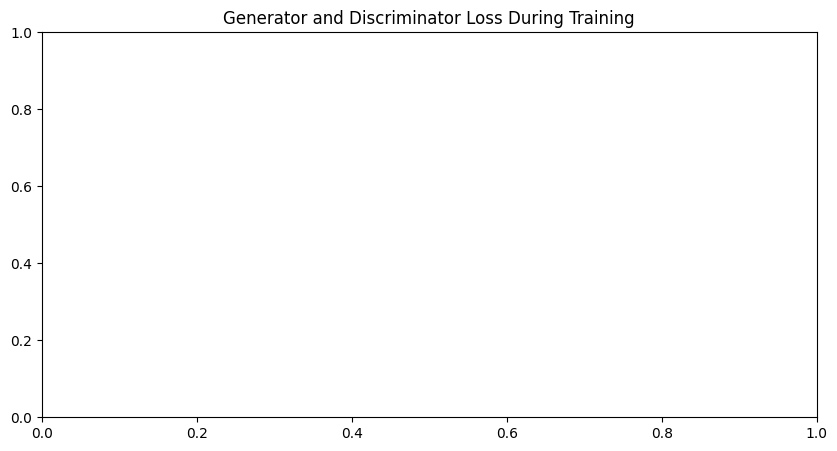

In [94]:
# Plot the loss values
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
# generator_losses
generator_losses = [generator_loss.to('cpu') for generator_loss in generator_losses]
plt.plot(generator_losses, label="G")
plt.plot(discriminator_losses.cpu().numpy(), label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [263]:

# After training, you can save your models if needed
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


In [99]:
res = generator(torch.randn(latent_dim).to(device))

In [102]:
res.shape

torch.Size([1, 1, 32, 32, 32])

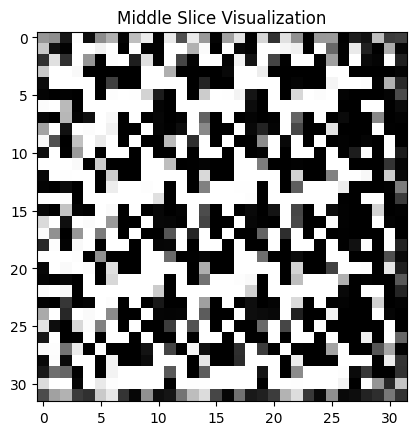

In [138]:
# Select a slice to visualize, for example, the middle slice along the first dimension
out = res.cpu()
slice_2d = out[0, 0, 16, :, :].detach().numpy()

# Plot the slice
plt.imshow(slice_2d, cmap='gray')
plt.title('Middle Slice Visualization')
plt.show()

In [139]:
out = out.squeeze().detach().numpy()

In [146]:
out.shape

(32, 32, 32)

In [132]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [172]:
voxel_grid_tensor = res.cpu().detach().squeeze()

In [126]:
pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-ip7dg4qb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-ip7dg4qb
  Running command git checkout -q f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit f34104cf6ebefacd7b7e07955ee7aaa823e616ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.6-cp310-cp310-linux_x86_64.whl size=56542864 sha256=783f5d36db3f28b97ef82847f2345be441f303b29946c1abc9c894cbbf69209b
  Stored in directory: /tmp/pip-ephem-wheel-cache-z2ucwkna/wheels/39/5f/20/2d3b6f3a35a60bdc0ba3c19da94340db9596637

In [159]:
import pytorch3d
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.structures import Pointclouds

In [162]:
res.shape

torch.Size([1, 1, 32, 32, 32])

In [166]:
output_tensor = res.cpu().detach()

In [167]:
output_tensor.shape

torch.Size([1, 1, 32, 32, 32])

In [198]:
slice_2d = output_tensor[0, 0, 16, :, :]

# Flatten the 2D slice to a 1D array and repeat it to create 3D points
points = torch.stack((slice_2d.flatten(), slice_2d.flatten(), slice_2d.flatten()), dim=1)
print(points.shape)
# Create a color array for the points
colors = np.full(points.shape, (1.0, 0.0, 0.0))  # Color the points red

# Create a PyTorch3D point cloud structure
point_cloud = Pointclouds(points=[points], features=[torch.tensor(colors)])

# Visualize the point cloud
plot_scene({
    "subplot1": {
        "pointcloud": point_cloud
    }
})

torch.Size([1024, 3])


In [115]:
!pip install PyQt5 PySide2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.3/164.3 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.4/975.4 kB 68.3 MB/s eta 0:00:00


In [116]:
os.environ['ETS_TOOLKIT'] = 'qt4'

In [119]:
!pip install mayavi

  Using cached mayavi-4.8.1-cp310-cp310-linux_x86_64.whl


In [ ]:
from mayavi import mlab
import torch


# Convert to NumPy and squeeze to remove single-dimensional entries
volume = res.cpu().detach().numpy().squeeze()

# Visualize the 3D volume
mlab.contour3d(volume)
mlab.show()


### ***Data Preparation: Preprocess your dataset to pair each text description with its corresponding voxel grid representation of the 3D model.***
Model Architecture:
Text Encoder: Convert text descriptions into a fixed-size vector representation, such as [1,1024].
Generator: Takes the output of the text encoder and generates voxel grids of size (16,16,16).
Discriminator: Takes voxel grids of size (16,16,16) as input and predicts whether they are real or generated.
Connecting the Components:
Pass the text description through the text encoder to get the fixed-size vector representation.
Feed this vector representation into the generator to produce a voxel grid.
Pass both the real voxel grids (from the dataset) and generated voxel grids through the discriminator.
Loss Functions:
Generator Loss: Use a combination of traditional image generation loss functions such as pixel-wise mean squared error (MSE) or binary cross-entropy loss.
Discriminator Loss: Train the discriminator to distinguish between real and generated voxel grids using binary cross-entropy loss.
Training:
Alternately train the generator and discriminator in a GAN-like setup:
Train the discriminator to correctly classify real and generated voxel grids.
Train the generator to fool the discriminator by generating voxel grids that the discriminator classifies as real.
Use techniques like mini-batch discrimination and label smoothing to improve stability.
Evaluation:
Assess the quality of generated 3D models using evaluation metrics such as Frechet Inception Distance (FID), Structural Similarity Index (SSIM), or human evaluation.
Fine-tuning and Iteration:
Fine-tune your model and experiment with different architectures, hyperparameters, and training strategies to improve performance.


Increasing the size of the voxel grid to (128, 128, 128) will have several implications:

Increased Memory Usage: Larger voxel grids require more memory to store both during training and inference. This means you'll need more RAM or VRAM, depending on whether you're training on CPU or GPU, respectively.
Higher Computational Complexity: With a larger grid, the number of voxels to process increases significantly. This leads to higher computational complexity for both the generator and discriminator networks, resulting in longer training times per iteration.
Architecture Adjustments: The architectures of the generator and discriminator networks will need to be adjusted to accommodate the larger input and output dimensions. For example, you may need to increase the number of layers, filters, or neurons in the networks to handle the increased complexity.
Training Stability: Larger voxel grids may lead to training instability, especially in the early stages of training. Techniques such as gradient clipping, batch normalization, and spectral normalization may be necessary to stabilize training.
Data Requirements: Generating high-resolution voxel grids requires more detailed and diverse training data to capture the complexity of real-world objects accurately. Ensure that your dataset is large and varied enough to support training with the larger voxel grid size effectively.
Evaluation Metrics: When evaluating the quality of generated models, consider using metrics that account for the increased resolution, such as voxel-based metrics or perceptual metrics like Frechet Inception Distance (FID) adapted for 3D data.
Hardware Limitations: Finally, ensure that your hardware can handle the increased memory and computational demands of training with larger voxel grids. High-performance GPUs with ample VRAM are typically required for training deep learning models with large inputs.
Overall, while increasing the voxel grid size to (128, 128, 128) may lead to higher-quality 3D model generation, it also comes with challenges related to memory usage, computational complexity, and training stability. Balancing these factors is essential for successful training and generation of high-fidelity 3D models.

In [255]:
# Generator architecture
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, noise_dim):
        super(ConditionalGenerator, self).__init__()
        self.fc = nn.Sequential(
          nn.Linear((latent_dim + noise_dim), 512 * 1 * 1 * 1),
          nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # or nn.Tanh(), depending on your data normalization
        )


    def forward(self, latent_description, noise):
        x = torch.cat((latent_description, noise), 1)  # Concatenate latent description and noise
        x = self.fc(x)
        print(x.shape)
        x = x.view(-1, 512, 1, 1, 1)  # Reshape to start the 3D volume
        print(x.shape)
        x = self.deconv(x)
        return x


In [257]:
latent_dim = 512
noise_dim = 512
generator = ConditionalGenerator(latent_dim, noise_dim).to(device)
latent_description_size = (1,latent_dim)
noise_size = (1,noise_dim)



# Call summary with the correct input size
# Note: The input size should match the expected input of the generator's forward method
summary(generator, input_size=[latent_description_size, noise_size])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x512 and 1024x512)

In [205]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(ConditionalDiscriminator, self).__init__()
        # Define the architecture for processing the voxel tensor
        self.conv = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout3d(0.4)
        )
        # Define the architecture for processing the latent description
        self.fc_latent = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Combine the outputs from the voxel tensor and latent description
        self.fc_combined = nn.Sequential(
            nn.Linear(256 * 4 * 4 * 4 + 256, 1),
            nn.Sigmoid()
        )

    def forward(self, voxel_tensor, latent_description):
        voxel_features = self.conv(voxel_tensor)
        voxel_features = voxel_features.view(-1, 256 * 4 * 4 * 4)  # Flatten the voxel features
        latent_features = self.fc_latent(latent_description)  # Process the latent description
        combined_features = torch.cat((voxel_features, latent_features), 1)  # Concatenate the features
        validity = self.fc_combined(combined_features)  # Determine validity (real or fake)
        return validity


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x1 and 2048x2048)

In [ ]:
discriminator = ConditionalDiscriminator()
summary(discriminator,(1,32,32,32) ,(1,1024))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 128  # Define your batch size
num_epochs = 1000  # Define the number of epochs
learning_rate = 0.0002  # Define the learning rate
train_loader = torch.utils.data.DataLoader(
    voxel_tensors_sq, batch_size=batch_size, shuffle=True
)
latent_dim = 1024
# latent_dim = latent_dim.astype(torch.float32)
#define generator and discriminator networks
generator = Generator(latent_dim)
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

def weights_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)

discriminator_losses =[]
generator_losses =[]
# Apply the initialization to the networks
generator.apply(weights_init)
discriminator.apply(weights_init)

# Assuming you have defined your loss function and optimizers
criterion = nn.BCELoss().to(device)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


def train_gen(train_loader):
    for  n, voxelgrid_tensor in enumerate(train_loader):
            # Data for training the discriminator

            voxelgrid_tensor.to(device)
            curr_batch_size = voxelgrid_tensor.size(0)  # Get the current batch size
            # print(curr_batch_size)
            # current_batch_size = voxelgrid_tensor.size(0)
            real_labels = torch.ones((curr_batch_size, 1)).to(device)
            fake_labels = torch.zeros(curr_batch_size, 1).to(device)

            latent_space_samples = torch.randn((curr_batch_size, latent_dim)).to(device)

            latent_space_samples = latent_space_samples.to(device)
            generated_samples = generator(latent_space_samples)

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator_real = discriminator(voxelgrid_tensor)
            output_discriminator_fake = discriminator(generated_samples.detach())  # Detach to avoid backpropagation through generator

            # print('output_discriminator_fake.shape',output_discriminator_fake.shape,'real_labels.shape',real_labels.shape)
            # print('output_discriminator_real.shape', type(output_discriminator_real),'torch.zeros_like(real_labels).shape',torch.zeros_like(real_labels).shape )

            # Compute discriminator loss
            loss_discriminator_real = criterion(output_discriminator_real, real_labels)
            loss_discriminator_fake = criterion(output_discriminator_fake,fake_labels)
            discriminator_loss = (loss_discriminator_real + loss_discriminator_fake) / 2
            # print('loss_discriminator_real :',loss_discriminator_real,'loss_discriminator_fake :',loss_discriminator_fake,'discriminator_loss :',discriminator_loss)

            discriminator_loss.backward()
            optimizer_discriminator.step()

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples).to(device)
            output_discriminator_generated = discriminator(generated_samples)

            # Calculate the generator loss
            loss_generator = criterion(output_discriminator_generated, real_labels)
            loss_generator.backward()
            optimizer_generator.step()
            # print('loss_generator :',loss_generator)
            discriminator_losses.append(discriminator_loss)
            generator_losses.append(loss_generator)
            # Show loss
            if (epoch % 10 == 0) and (n == len(train_loader) - 1):
                print(f"Epoch: {epoch} Loss D.: {discriminator_loss.item()}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator.item()}")

for epoch in range(num_epochs):
    # for name, param in discriminator.named_parameters():
        # if param.requires_grad:
            # print(name, param.grad)

    train_gen(train_loader)

Streaming output truncated to the last 5000 lines.
loss_generator : tensor(53.3926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.3813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.3509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.3458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.4551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.2974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.2981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.4557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss_generator : tensor(53.5287, device='cuda:0', grad_fn=<